In [ ]:
!pip install git+https://github.com/IBM/AutoPeptideML

Processing /Users/raulfd/Projects/Peptides/APML_Project/AutoPeptideML
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'autopeptideml' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'autopeptideml'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for autopeptideml: filename=autopeptideml-2.0.2-py3-none-any.whl size=16978979 sha256=638721d4e1d59913991ade0e85d8c80dc837e137014ab2f788f3baea2fcbbdc2
  Stored in directory: /private/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/pip-ephem-wheel-cache-_02eu6et/wheels/9c/c6/f1/7ecf7a27375efab6e28e56e31c784ba646628e1c5d8d12d315
Successfully built autopeptideml
  Attempting uninstall: autopeptideml
   

In [2]:
import pandas as pd
from autopeptideml import AutoPeptideML

# Load data
df = pd.read_csv('c-antiviral.csv')
df = df[df['labels'] == 1].sample(100)
df2 = pd.read_csv('nc-antiviral.csv')
df2 = df2[df2['labels'] == 1]
all_inputs = df['sequence'].tolist() + df2['SMILES'].tolist()

# Initialise AutoPeptideML
apml = AutoPeptideML(
    data=all_inputs,
    outputdir='demo'
)

# Preprocess
apml.preprocess_data(
    pipeline='to-smiles',
    n_jobs=5,
    verbose=True
)

Executing preprocessing step 1 of 2: to-smiles-1
Executing preprocessing step 1 of 2: to-smiles-1a
Executing preprocessing step 1 of 3: filter-smiles


100%|██████████| 321/321 [00:02<00:00, 115it/s]  


Executing preprocessing step 2 of 3: canonical-cleaner


100%|██████████| 100/100 [00:02<00:00, 35.9it/s] 


Executing preprocessing step 3 of 3: sequence-to-smiles


100%|██████████| 100/100 [00:02<00:00, 33.8it/s] 


Executing preprocessing step 2 of 2: to-smiles-1b
Executing preprocessing step 1 of 1: filter-smiles


100%|██████████| 321/321 [00:02<00:00, 112it/s]  


Executing preprocessing step 2 of 2: canonicalize-smiles


100%|██████████| 321/321 [00:02<00:00, 111it/s]  


In [3]:
# Check distribution of labels
apml.df.label.value_counts()

label
1    321
Name: count, dtype: int64

In [4]:
# Sample negatives
apml.sample_negatives(
    target_db='both',
    activities_to_exclude='Antibacterial',
    desired_ratio=1.0,
    sample_by='mw',
    n_jobs=10
)

label
1    321
0    321
Name: count, dtype: int64

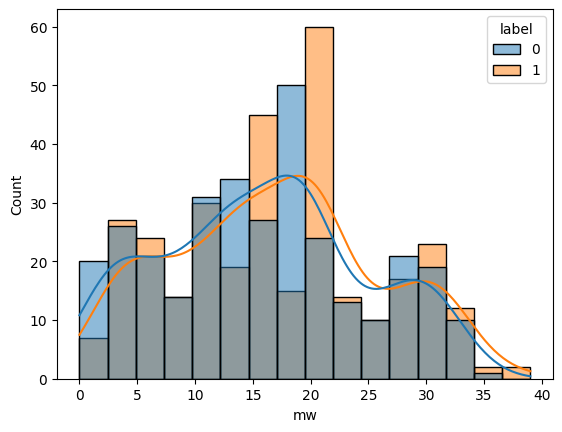

In [5]:
# Check distribution of labels after negative sampling
import seaborn as sns

sns.histplot(apml.df, x='mw', hue='label', kde=True, alpha=0.5)
apml.df.label.value_counts()

In [6]:
# Build models
apml.build_models(split_strategy='min',
                  task='class',
                  reps=['chemberta-2', 'ecfp', 'esm2-8m', 'peptideclm'],
                  device='mps', # Change to cuda if using hardware acceleartion
                  models=['svm', 'rf'],
                  n_trials=50)

Partitioning...
Initialising Hestia Dataset Generator
Number of items in data: 642
Calculating similarity...
Calculating molecular similarities using mapc with 2,048 bits, radius 4 and jaccard index...


Similarity calculation: 100%|██████████| 642/642 [00:00<00:00, 1.12kit/s]


Similarity successfully calculated!
Calculating partitions...


100%|██████████| 8/8 [00:00<00:00, 106.15it/s]

Partitions successfully calculated!
Executing preprocessing step 1 of 2: to-sequences-1
Executing preprocessing step 1 of 2: to-sequences-1a
Executing preprocessing step 1 of 1: filter-smiles



100%|██████████| 642/642 [00:03<00:00, 165it/s]  


Executing preprocessing step 2 of 2: to-sequences-1b
Executing preprocessing step 1 of 2: filter-smiles


100%|██████████| 642/642 [00:03<00:00, 169it/s]  


Executing preprocessing step 2 of 2: smiles-to-sequence


100%|██████████| 642/642 [00:12<00:00, 53.2it/s] 


Executing preprocessing step 2 of 2: canonical-cleaner


100%|██████████| 642/642 [00:03<00:00, 191it/s]  


Computing chemberta-2 representations...


100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


Computing ecfp representations...


100%|██████████| 6/6 [00:00<00:00,  9.48it/s]


Computing esm2-8m representations...


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


Computing peptideclm representations...


100%|██████████| 41/41 [00:08<00:00,  4.94it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

<Axes: title={'center': 'Optimization history'}, xlabel='Trial', ylabel='MCC'>

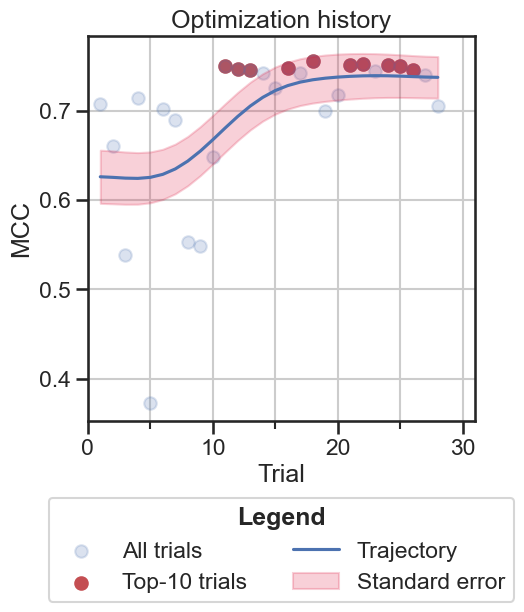

In [7]:
from autopeptideml.utils.hpo_plots import plot_optimization_history

plot_optimization_history(apml.trainer.history)

<Axes: title={'center': 'Model vs Representation (Annotated with Trial Count)'}, xlabel='Representation', ylabel='Model'>

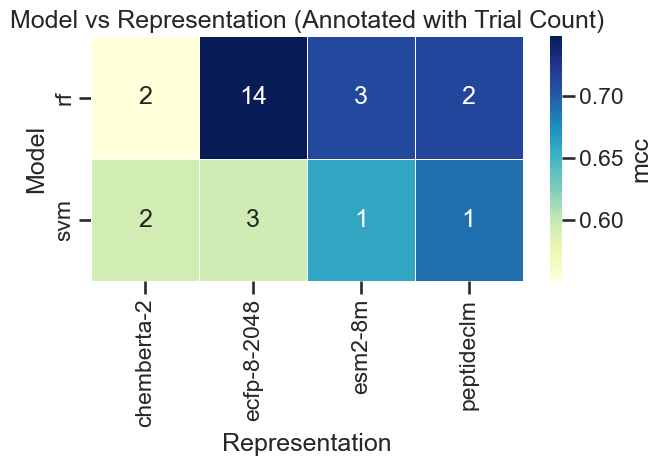

In [8]:
from autopeptideml.utils.hpo_plots import plot_model_vs_rep

plot_model_vs_rep(apml.trainer.history)

In [9]:
apml._evaluating(task='class')

In [10]:
apml.trainer.history

,mcc,acc,f1,f1_weighted,precision,recall,auroc,tp,tn,fp,fn,name,variables,representation,fold,run,Representation,Model,Run
0,0.660471,0.825243,0.823529,0.825111,0.893617,0.763636,0.898106,42,43,13,5,rf,"{'n_estimators': 13, 'max_depth': 15, 'min_sam...",peptideclm,0,1,peptideclm,rf,1
1,0.699469,0.825243,0.804348,0.821944,1.000000,0.672727,0.832197,37,48,18,0,rf,"{'n_estimators': 13, 'max_depth': 15, 'min_sam...",peptideclm,1,1,peptideclm,rf,1
2,0.816769,0.902913,0.901961,0.902839,0.978723,0.836364,0.926894,46,47,9,1,rf,"{'n_estimators': 13, 'max_depth': 15, 'min_sam...",peptideclm,2,1,peptideclm,rf,1
3,0.715150,0.834951,0.821053,0.832823,1.000000,0.696429,0.898176,39,47,17,0,rf,"{'n_estimators': 13, 'max_depth': 15, 'min_sam...",peptideclm,3,1,peptideclm,rf,1
4,0.646380,0.803922,0.787234,0.801494,0.948718,0.672727,0.880077,37,45,18,2,rf,"{'n_estimators': 13, 'max_depth': 15, 'min_sam...",peptideclm,4,1,peptideclm,rf,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.656073,0.825243,0.826923,0.825342,0.877551,0.781818,0.890152,43,42,12,6,rf,"{'n_estimators': 85, 'max_depth': 31, 'min_sam...",esm2-8m,0,28,esm2-8m,rf,28
1,0.665916,0.825243,0.820000,0.824748,0.911111,0.745455,0.881818,41,44,14,4,rf,"{'n_estimators': 85, 'max_depth': 31, 'min_sam...",esm2-8m,1,28,esm2-8m,rf,28
2,0.755682,0.873786,0.873786,0.873786,0.937500,0.818182,0.931061,45,45,10,3,rf,"{'n_estimators': 85, 'max_depth': 31, 'min_sam...",esm2-8m,2,28,esm2-8m,rf,28
3,0.738620,0.864078,0.865385,0.864180,0.937500,0.803571,0.942629,45,44,11,3,rf,"{'n_estimators': 85, 'max_depth': 31, 'min_sam...",esm2-8m,3,28,esm2-8m,rf,28


In [11]:
from os import path as osp

input_trial = {rep: apml.x[rep][:10] for rep in apml.trainer.best_model.reps}
preds = apml.trainer.best_model.predict(input_trial)

apml.trainer.best_model.save(osp.join(apml.outputdir, 'ensemble'))

In [12]:
from autopeptideml.train.architectures import VotingEnsemble
ensemble = VotingEnsemble.load(osp.join(apml.outputdir, 'ensemble'))


preds = apml.trainer.best_model.predict(input_trial)[0]
preds2 = ensemble.predict(input_trial)[0]
